In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

In [2]:
df_fake = pd.read_csv("../data/raw/Fake.csv")
df_true = pd.read_csv("../data/raw/True.csv")

In [3]:
df_fake["label"] = 1   # Fake
df_true["label"] = 0   # Real

df = pd.concat([df_fake, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head())

                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      1  
1       April 5, 2017       0  
2  September 27, 2017       0  
3         May 22, 2017      1  
4       June 24, 2016       0  


In [4]:
X = df["text"].astype(str).values
y = df["label"].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [6]:
MAX_VOCAB = 20000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

print("Train shape:", X_train_pad.shape, "Test shape:", X_test_pad.shape)

Train shape: (35918, 300) Test shape: (8980, 300)


In [7]:
def build_rnn_model():
    model = Sequential([
        Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
        SimpleRNN(64, return_sequences=False),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])
    return model

def build_lstm_model():
    model = Sequential([
        Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
        LSTM(64, return_sequences=False),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])
    return model

def build_gru_model():
    model = Sequential([
        Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
        GRU(64, return_sequences=False),
        Dense(64, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer=Adam(1e-3), metrics=["accuracy"])
    return model

C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 98s 421ms/step - accuracy: 0.7595 - loss: 0.4578 - val_accuracy: 0.9587 - val_loss: 0.1607
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 97s 432ms/step - accuracy: 0.9393 - loss: 0.2427 - val_accuracy: 0.9399 - val_loss: 0.2362
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 100s 443ms/step - accuracy: 0.9401 - loss: 0.2193 - val_accuracy: 0.9548 - val_loss: 0.1595
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 103s 458ms/step - accuracy: 0.9409 - loss: 0.2087 - val_accuracy: 0.9605 - val_loss: 0.1549
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 92s 407ms/step - accuracy: 0.8927 - loss: 0.2745 - val_accuracy: 0.5979 - val_loss: 0.6167
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step
              precision    recall  f1-score   support

           0       0.57      0.50      0.53      4284
           1       0.59      0.66      0.62      4696

    accuracy                           0.58      8980
   macro avg       0.58      0.58      0.58      8980
weighted avg       0.58      0.58

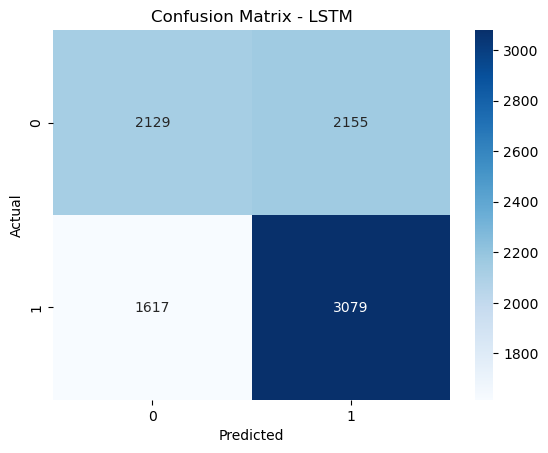

In [8]:
# --- Train Example (LSTM) ---
lstm_model = build_lstm_model()
history = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    verbose=1
)

# --- Evaluation ---
y_pred = (lstm_model.predict(X_test_pad) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM")
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# 1. إعداد الباراميترات
vocab_size = 10000   # عدد الكلمات المسموح بيها (خليها أكبر من 5000 لتفادي المشكلة)
maxlen = 500         # الطول الأقصى للجملة (padding)

# 2. Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 3. Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# 4. Split train/val
X_train_pad, X_val_pad, y_train, y_val = train_test_split(
    X_train_pad, y_train, test_size=0.2, random_state=42
)

# 5. بناء الموديل
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 6. Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 7. EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# 8. Train
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stop]
)


Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.5153 - loss: 0.6925 - val_accuracy: 0.5335 - val_loss: 0.6872
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.7647 - loss: 0.4658 - val_accuracy: 0.9145 - val_loss: 0.2885
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.9218 - loss: 0.2722 - val_accuracy: 0.9187 - val_loss: 0.2617
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.9216 - loss: 0.2632 - val_accuracy: 0.9215 - val_loss: 0.2537
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.9261 - loss: 0.2488 - val_accuracy: 0.9271 - val_loss: 0.2392
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.9334 - loss: 0.2312 - val_accuracy: 0.9372 - val_loss: 0.2235
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 218s 970ms/step - accuracy: 0.9279 - loss: 0.2449 - val_accuracy: 0.9314 - val_loss: 0.2236
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 218s 969ms/step - accuracy: 0.9363 - loss: 0.2279 - va

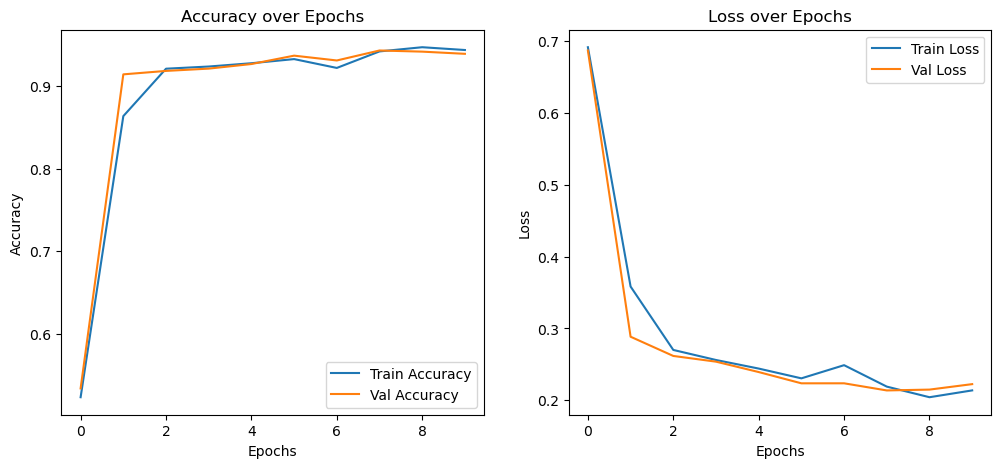

In [14]:
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


281/281 ━━━━━━━━━━━━━━━━━━━━ 40s 142ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94      4284
           1       0.96      0.92      0.94      4696

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



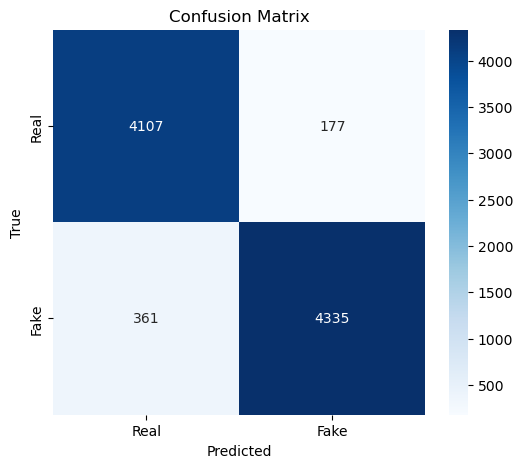

In [15]:
y_pred_probs = model.predict(X_test_pad)
y_pred = (y_pred_probs > 0.5).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'],
            yticklabels=['Real','Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
model.save("../models/lstm_model.h5")

# حفظ الـ Tokenizer علشان نستخدمه في الـ Flask backend
joblib.dump(tokenizer, "../models/tokenizer.pkl")

print("✅ Model and tokenizer saved successfully!")

✅ Model and tokenizer saved successfully!


281/281 ━━━━━━━━━━━━━━━━━━━━ 45s 161ms/step


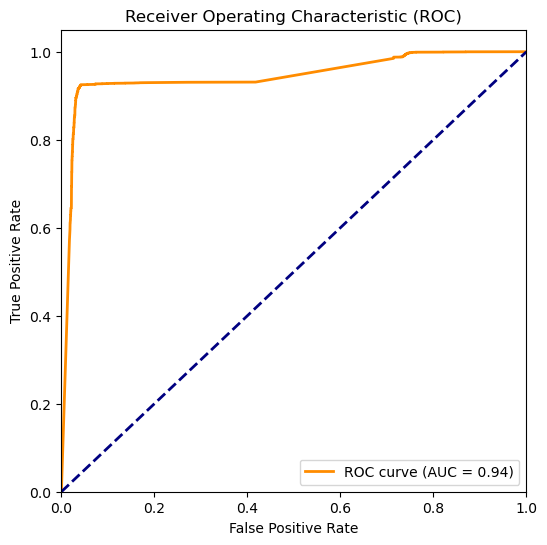

AUC Score: 0.943883444916865


In [18]:
y_pred_proba = model.predict(X_test_pad).ravel()

# حساب الـ ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# رسم الـ ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# طباعة الـ AUC Score مباشرة
print("AUC Score:", roc_auc_score(y_test, y_pred_proba))